# INIT

## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importacion datos

In [2]:
from mongo_local_module import connect_to_db, get_collection_as_dataframe

## Conectar a db

In [3]:
db_name = 'ds_market'         # Nombre de la base de datos

# Conectar a la base de datos
db = connect_to_db(db_name, local=True)

Conexión exitosa


## Obtener colecciones

In [4]:
# Diccionario colecciones
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

In [5]:
df_cal = get_collection_as_dataframe(db, 'calendar').drop(columns='_id')
# Se añadieron columnas week y month a calendar para hacer cruces de datos mas faciles

df_cal = df_cal.fillna('None') # event tiene NaN

display(df_cal.head())

El número de documentos en la colección 'calendar' es: 1913


,date,weekday,weekday_int,d,event,month,week
0,2011-01-29,Saturday,1,d_1,None,1,4
1,2011-01-30,Sunday,2,d_2,None,1,4
2,2011-01-31,Monday,3,d_3,None,1,5
3,2011-02-01,Tuesday,4,d_4,None,2,5
4,2011-02-02,Wednesday,5,d_5,None,2,5


In [6]:
df_shops = get_collection_as_dataframe(db, 'tiendas').drop(columns='_id')
df_items = get_collection_as_dataframe(db, 'items').drop(columns='_id')

df_ws = get_collection_as_dataframe(db, 'weekly_sales').drop(columns='_id')

# Añadimos eventos para no perder esa información
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()

# Añadir la columna 'event' a df_ws usando el método 'map'
df_ws['event'] = df_ws['week'].map(event_dict)

El número de documentos en la colección 'tiendas' es: 10
El número de documentos en la colección 'items' es: 3049
El número de documentos en la colección 'weekly_sales' es: 5016091


# Creacion caracteristicas

In [7]:
import feature_creation_module as fcm

In [8]:
# Creacion caracteristicas para productos basadas en ventas/performance
fc_config = {
    'target_df':'items',
    'agg_primitives':['sum', 'mean', 'std', 'count'],  
    'trans_primitives':[],
    'max_depth':2
}

feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, fall

In [9]:
# Revision definiciones caracteristicas creadas
fcm.get_features_descriptions(feature_defs)

<Feature: category>: The "category".
<Feature: department>: The "department".
<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "item" in "items".
<Feature: STD(sales.raw_earn)>: The standard deviation of the "raw_earn" of all instances of "sales" for each "item" in "items".
<Feature: STD(sales.sell_price)>: The standard deviation of the "sell_price" of all instances of "sales" for each "item" in 

In [10]:
# Seleccionar y renombrar características relevantes para el clustering de productos ventas/performance
selected_features = {
    'COUNT(sales)': 'num_sales',                   
    'SUM(sales.units)': 'total_units_sold',        
    'SUM(sales.raw_earn)': 'total_revenue',        
    'MEAN(sales.sell_price)': 'avg_sell_price',    
    'STD(sales.sell_price)': 'std_sell_price',     
    'STD(sales.units)': 'std_units_sold',          
    'MEAN(sales.units)': 'avg_units_per_week',     
    'MEAN(sales.week)': 'avg_week',                
    'STD(sales.week)': 'std_week',                 
    'MEAN(sales.year)': 'avg_year'                 
}

feature_matrix = fcm.select_features(feature_matrix, selected_features)

__Filtrado caracteristicas usando liberira FeatureTools__
**Feature encode** (codifica categorical)

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-encoding

**Feature selection**

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-selection  
  
- *remove_low_information_features(feature_matrix)*  
Select features that have at least 2 unique values and that are not all null

- *remove_highly_correlated_features(feature_matrix)*  
Removes columns in feature matrix that are highly correlated with another column.

- *remove_highly_null_features(feature_matrix)*  
Removes columns from a feature matrix that have higher than a set threshold of null values.

- *remove_single_value_features(feature_matrix)*  
Removes columns in feature matrix where all the values are the same.

In [11]:
# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix)

display(filtered_feature_matrix.head(5))

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 10
Shape after filtering: 9
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,COUNT(sales),SUM(sales.units),SUM(sales.raw_earn),MEAN(sales.sell_price),STD(sales.sell_price),STD(sales.units),MEAN(sales.week),STD(sales.week),MEAN(sales.year)
item,,,,,,,,,
ACCESORIES_1_001,1185,4093.0,44559.7348,11.012286,0.187744,2.236397,27.129114,15.691742,2014.459916
ACCESORIES_1_002,1899,5059.0,26639.4744,5.276624,0.090513,2.209479,27.790416,15.150502,2013.292786
ACCESORIES_1_003,665,1435.0,5533.7310,3.937700,0.182242,1.626411,23.950376,15.015021,2014.908271
ACCESORIES_1_004,2512,39175.0,234283.9156,5.985903,0.266703,12.957875,25.860669,15.162379,2013.216959
ACCESORIES_1_005,2134,14621.0,55310.5903,3.825727,0.227320,4.942326,27.065136,15.363908,2013.463449


In [12]:
# Renombrar características si es necesario
feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, selected_features)

In [13]:
feature_matrix_renamed.head(10)

,Num Sales,Total Units Sold,Total Revenue,Avg Sell Price,Std Sell Price,Std Units Sold,Avg Week,Std Week,Avg Year
item,,,,,,,,,
ACCESORIES_1_001,1185,4093.0,44559.7348,11.012286,0.187744,2.236397,27.129114,15.691742,2014.459916
ACCESORIES_1_002,1899,5059.0,26639.4744,5.276624,0.090513,2.209479,27.790416,15.150502,2013.292786
ACCESORIES_1_003,665,1435.0,5533.7310,3.937700,0.182242,1.626411,23.950376,15.015021,2014.908271
ACCESORIES_1_004,2512,39175.0,234283.9156,5.985903,0.266703,12.957875,25.860669,15.162379,2013.216959
ACCESORIES_1_005,2134,14621.0,55310.5903,3.825727,0.227320,4.942326,27.065136,15.363908,2013.463449
ACCESORIES_1_006,1736,13068.0,17288.1912,1.334689,0.053361,6.137553,25.953341,14.985165,2013.744240
ACCESORIES_1_007,1428,3014.0,31327.2190,10.478880,0.155090,1.304544,27.012605,15.763711,2014.044118
ACCESORIES_1_008,2375,87645.0,55054.6850,0.630134,0.025067,29.747971,25.042526,15.051956,2013.376842
ACCESORIES_1_009,2319,15657.0,35707.9996,2.290563,0.101603,5.090507,25.885295,15.213231,2013.226822


**Descripción algunas de las características creadas**

**Desviación estándar de las semanas de venta (`STD(sales.week)`):**  

Esta métrica revela si las ventas de un producto están concentradas en ciertos períodos del año o dispersas. Un alto valor indica ventas distribuidas, mientras que un valor bajo sugiere un patrón estacional claro. Esto es útil para identificar productos estacionales.

**Media de los años de venta (`MEAN(sales.year)`):**  

La media de los años de venta muestra cuándo los productos han sido más populares, ayudando a detectar si una tendencia es reciente o si un producto está en declive. Esto facilita el agrupamiento de productos según su ciclo de vida y relevancia actual.

**Media de las semanas de venta (`MEAN(sales.week)`):**  

Esta métrica indica en qué parte del año un producto suele venderse más. Permite agrupar productos según su popularidad en diferentes épocas, ayudando a identificar patrones estacionales y planificar estrategias de ventas e inventario.

# Preprocesamiento de los datos

In [14]:
import preprocessing_module as pm

In [15]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 9


In [16]:
scaled_df.head()

,Num Sales,Total Units Sold,Total Revenue,Avg Sell Price,Std Sell Price,Std Units Sold,Avg Week,Std Week,Avg Year
0,-0.496040,-0.317794,0.024548,1.500101,0.214006,-0.352174,1.093335,0.696325,0.967864
1,0.210891,-0.261289,-0.265924,0.241148,-0.233545,-0.356651,1.742089,-0.211576,-0.182634
2,-1.010891,-0.473269,-0.608030,-0.052740,0.188680,-0.453624,-2.025088,-0.438839,1.409830
3,0.817822,1.734265,3.099809,0.396832,0.577454,1.430975,-0.151042,-0.191653,-0.257381
4,0.443564,0.298023,0.198809,-0.077317,0.396175,0.097864,1.030571,0.146401,-0.014403


# Kmeans

In [17]:
import kmeans_module as km_m

### Elbow & Silouette

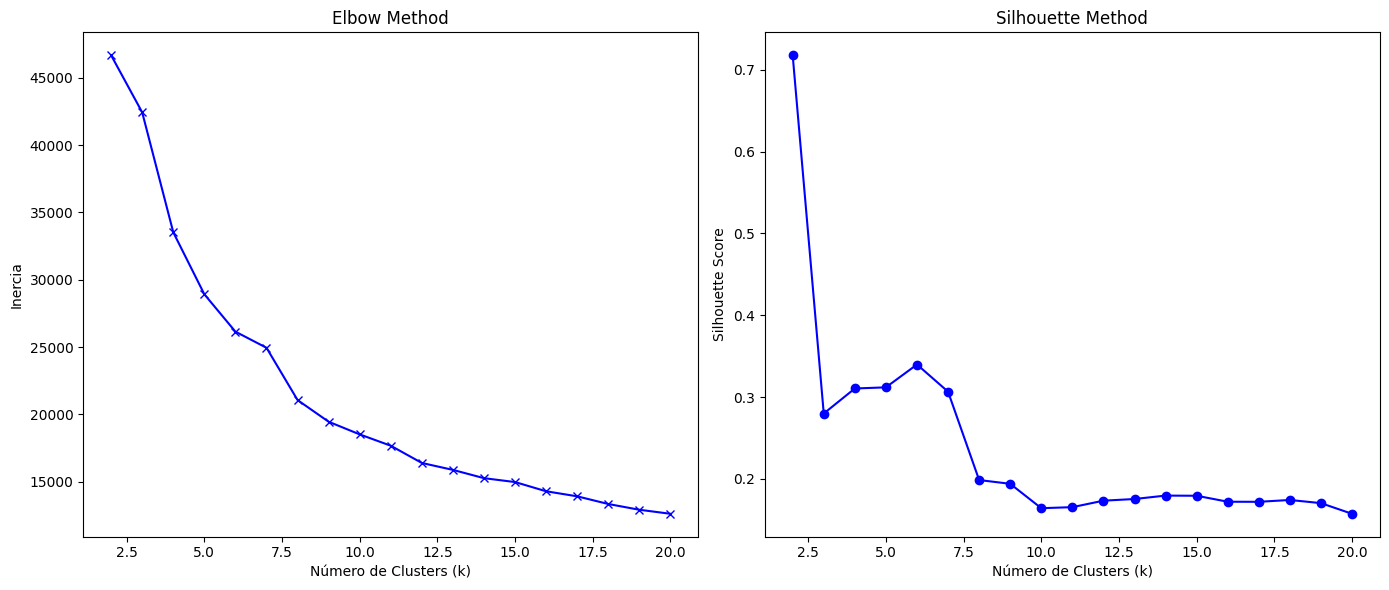

In [18]:
km_m.plot_elbow_silhouette(scaled_df, 20)

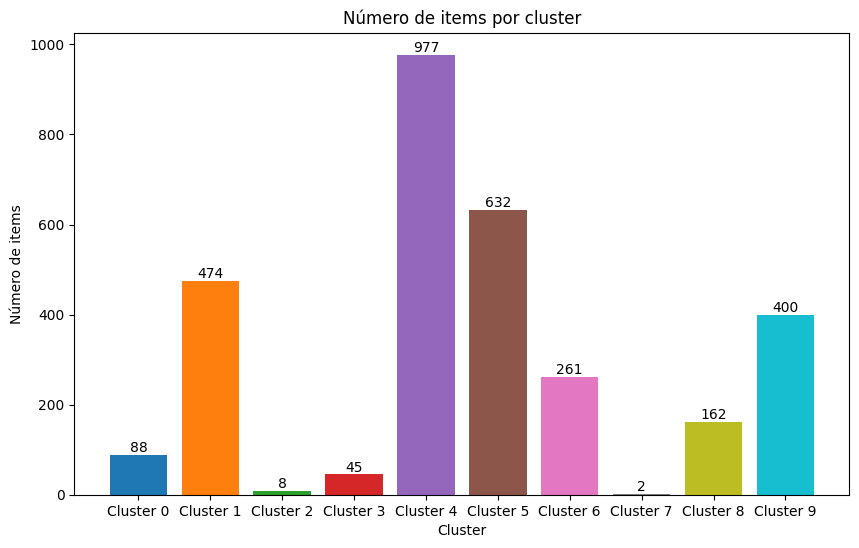

,Num Sales,Total Units Sold,Total Revenue,Avg Sell Price,Std Sell Price,Std Units Sold,Avg Week,Std Week,Avg Year,Cluster
item,,,,,,,,,,
ACCESORIES_1_001,1185,4093.0,44559.7348,11.012286,0.187744,2.236397,27.129114,15.691742,2014.459916,5
ACCESORIES_1_002,1899,5059.0,26639.4744,5.276624,0.090513,2.209479,27.790416,15.150502,2013.292786,5
ACCESORIES_1_003,665,1435.0,5533.7310,3.937700,0.182242,1.626411,23.950376,15.015021,2014.908271,4
ACCESORIES_1_004,2512,39175.0,234283.9156,5.985903,0.266703,12.957875,25.860669,15.162379,2013.216959,1
ACCESORIES_1_005,2134,14621.0,55310.5903,3.825727,0.227320,4.942326,27.065136,15.363908,2013.463449,5


In [19]:
optimal_k = 10 # Segun silueta

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

In [36]:
feature_matrix_with_clusters.shape

(3049, 10)

### Analisis

#### PCAs

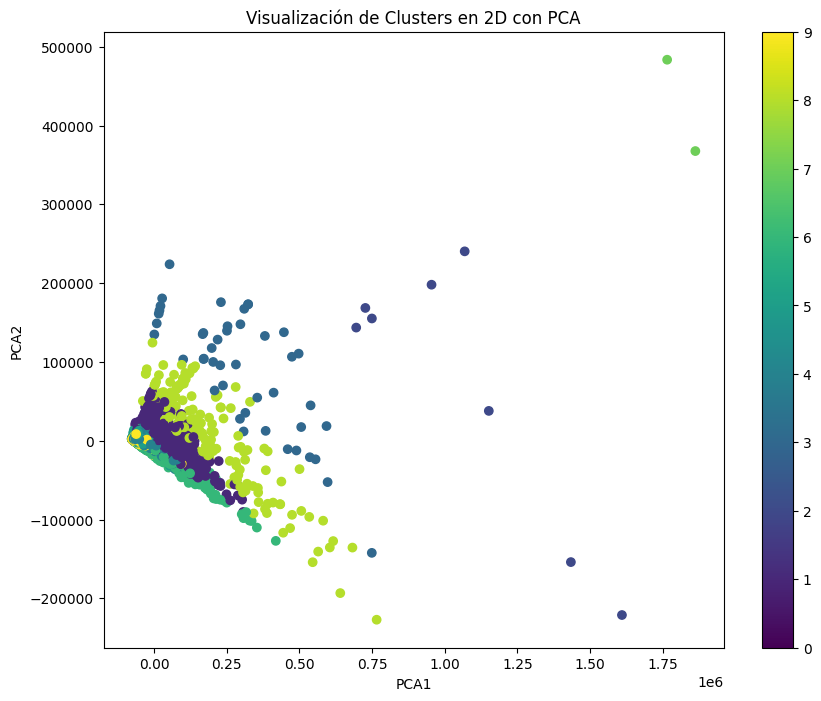

,PCA1,PCA2,Cluster
0,-34520.501484,-7649.051016,5
1,-51364.407960,-1458.831447,5
2,-72605.809952,1276.347467,4
3,157139.321578,-29860.020892,1
4,-21148.884724,-742.952540,5


In [20]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 0.94
Principal Component 2: 0.06
Principal Component 3: 0.00
Principal Component 4: 0.00
Principal Component 5: 0.00
Principal Component 6: 0.00
Principal Component 7: 0.00
Principal Component 8: 0.00
Principal Component 9: 0.00
Principal Component 10: 0.00


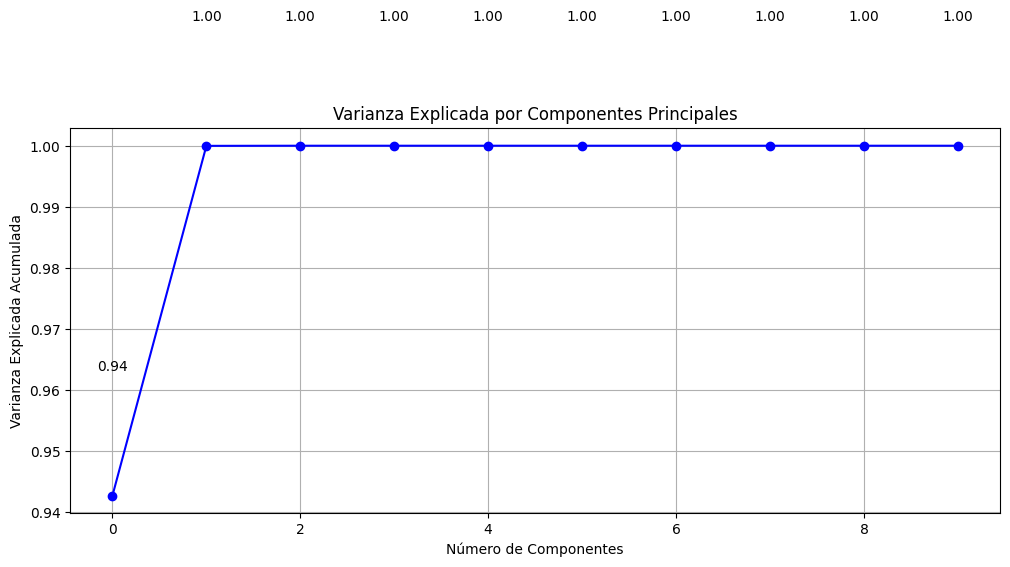

array([9.42719359e-01, 5.72592991e-02, 2.13383840e-05, 1.94592018e-09,
       9.81108418e-10, 3.65863691e-10, 9.19489093e-11, 3.65672307e-11,
       9.65971932e-12, 3.10261417e-12])

In [21]:
km_m.pca_variance_plot(feature_matrix_with_clusters)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 9


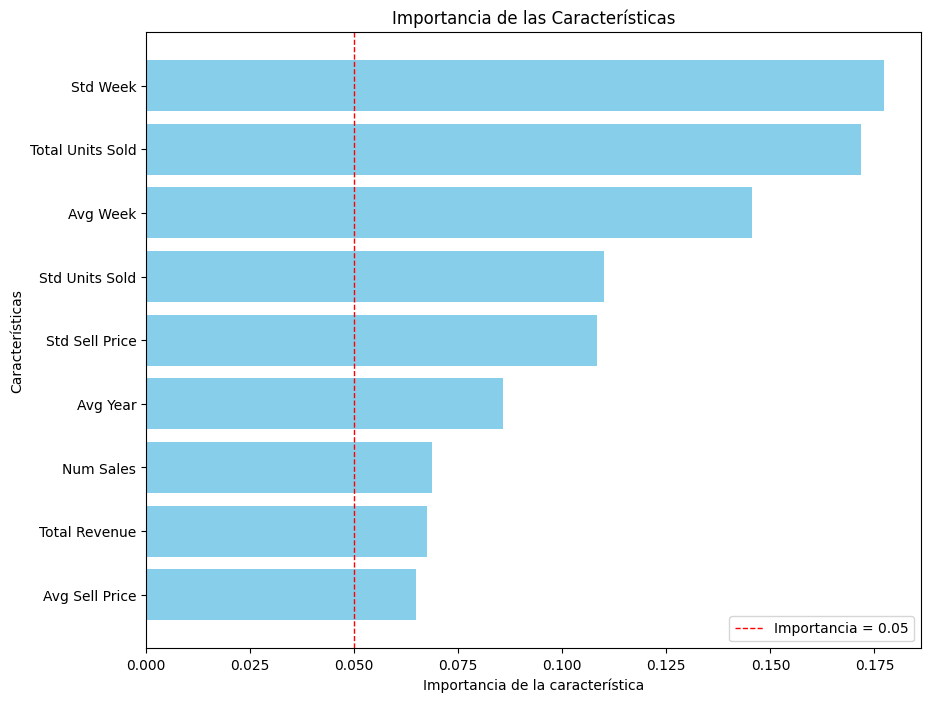

,Feature,Importance
0,Std Week,0.177313
1,Total Units Sold,0.171813
2,Avg Week,0.145588
3,Std Units Sold,0.110003
4,Std Sell Price,0.108451
5,Avg Year,0.085716
6,Num Sales,0.068596
7,Total Revenue,0.067605
8,Avg Sell Price,0.064916


In [22]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

# sales_importance_df = km_m.get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
sales_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=0.05)

display(sales_importance_df.head(10))

### Dimension Redux

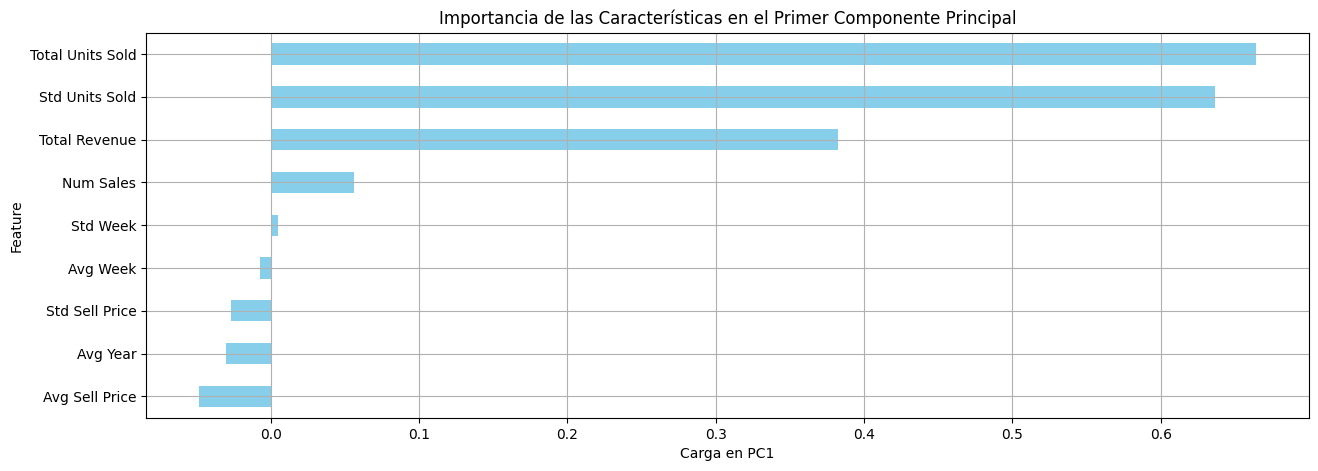

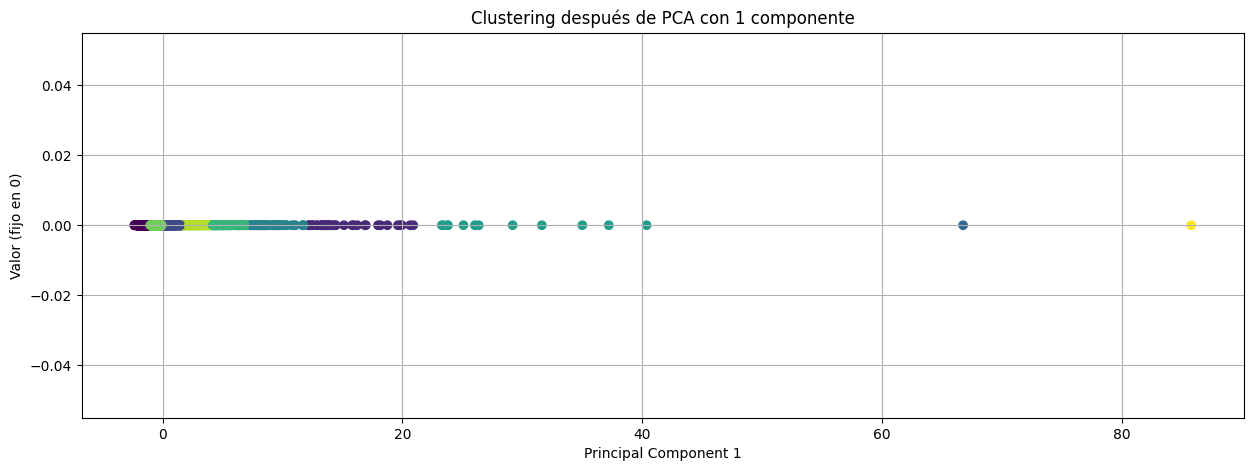

In [23]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

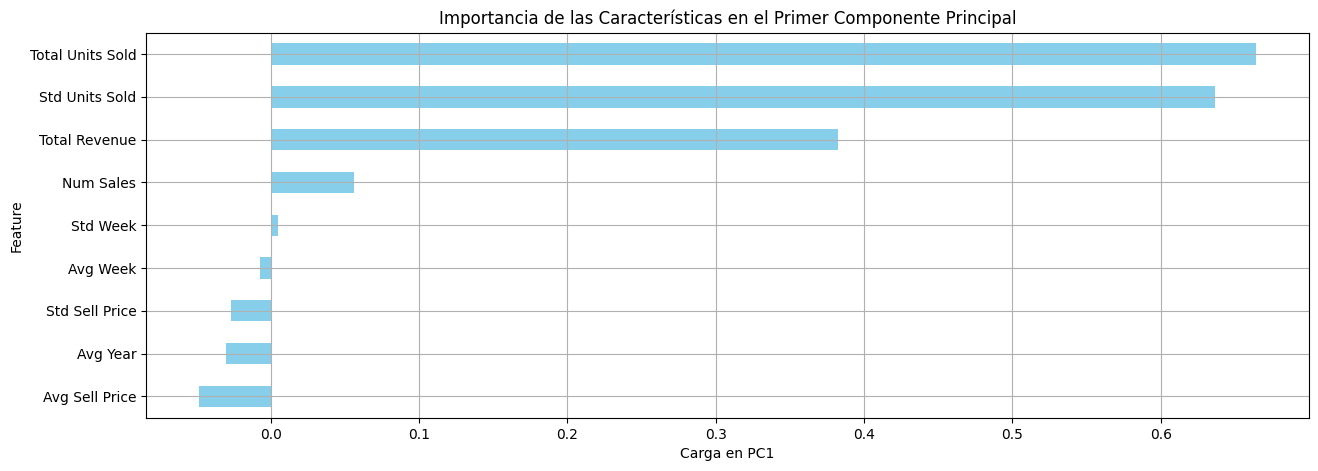

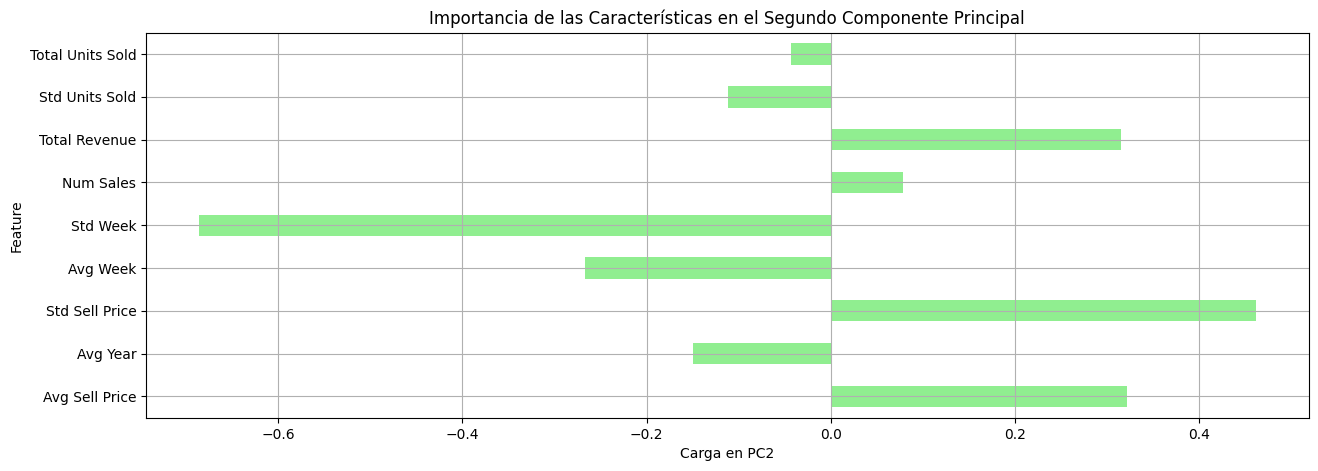

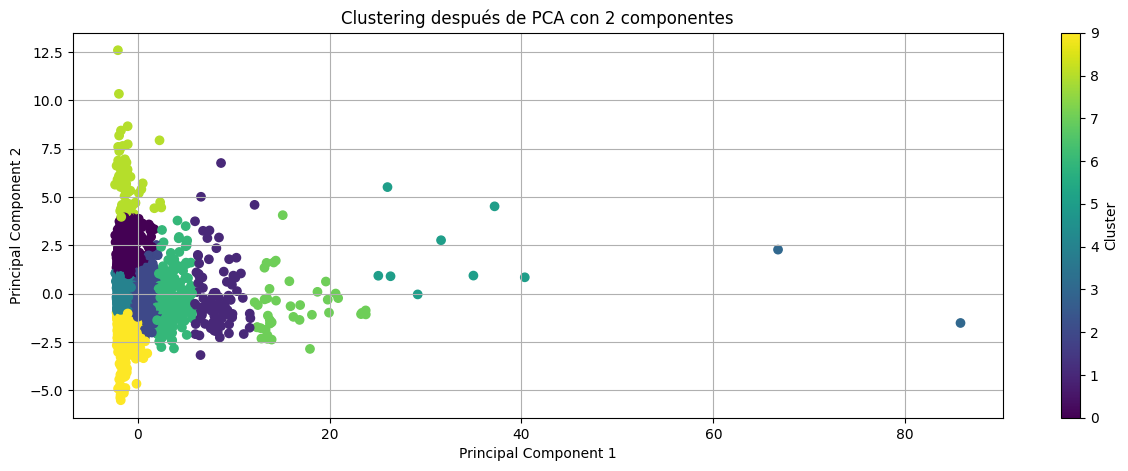

In [24]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

# CLUSTERING MODULE

In [25]:
import clustering_module as cm

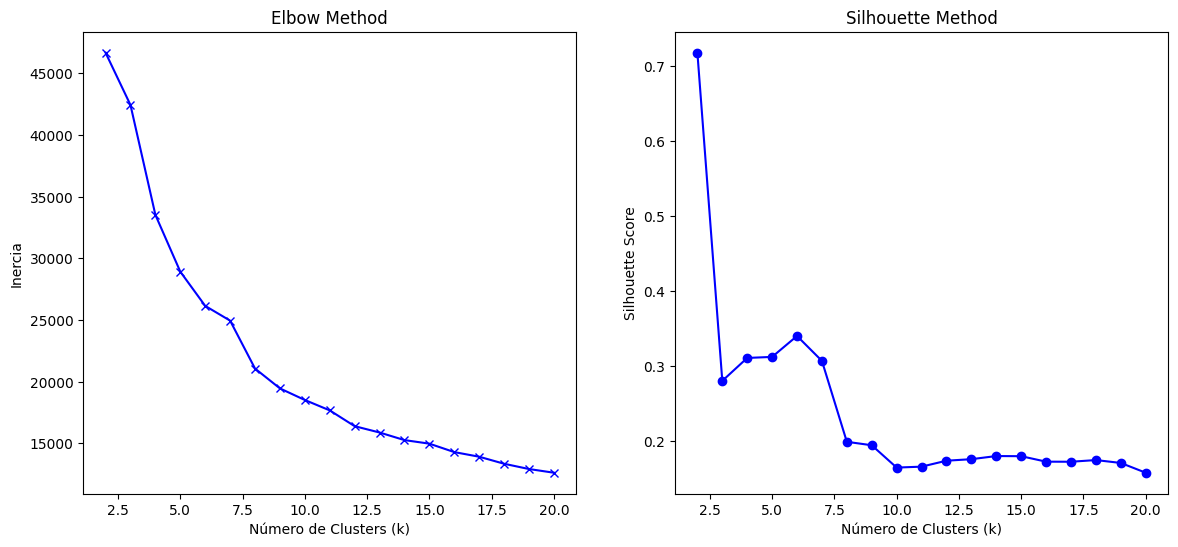

Cargas de PCA:
                       PC1       PC2
Num Sales         0.055834  0.078406
Total Units Sold  0.664031 -0.042945
Total Revenue     0.382568  0.315114
Avg Sell Price   -0.048430  0.321227
Std Sell Price   -0.026927  0.461299
Std Units Sold    0.636808 -0.112036
Avg Week         -0.007315 -0.266537
Std Week          0.005169 -0.686174
Avg Year         -0.030187 -0.149327

Contribuciones de las características a cada componente PCA:
                       PC1       PC2
Num Sales         0.003117  0.006148
Total Units Sold  0.440937  0.001844
Total Revenue     0.146359  0.099297
Avg Sell Price    0.002345  0.103187
Std Sell Price    0.000725  0.212797
Std Units Sold    0.405525  0.012552
Avg Week          0.000054  0.071042
Std Week          0.000027  0.470835
Avg Year          0.000911  0.022299


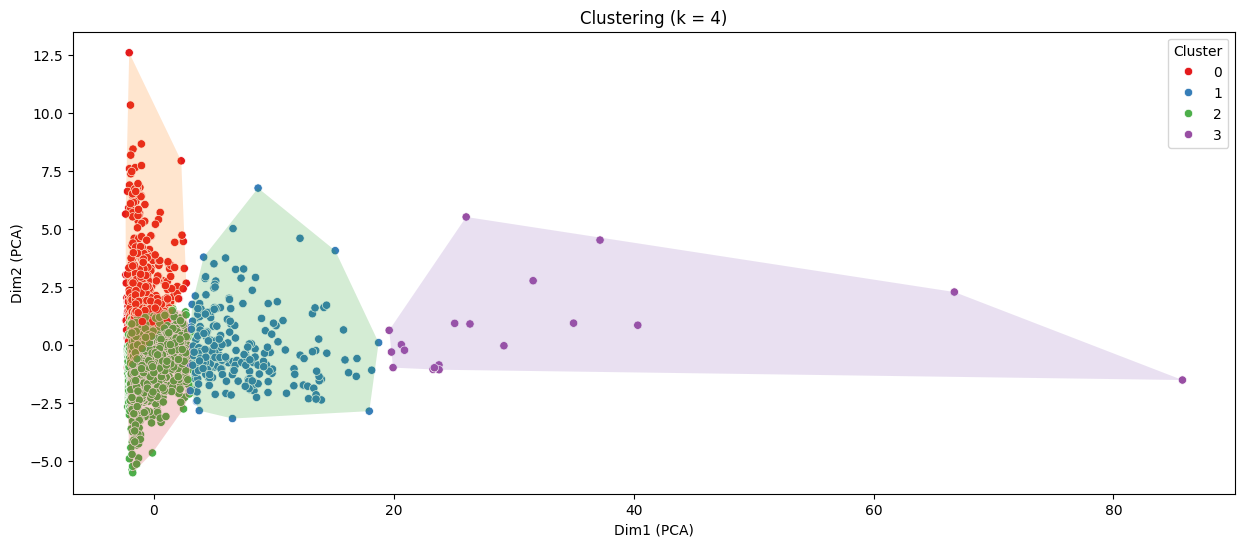

In [26]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    feature_matrix_renamed, method='kmeans', n_clusters=4
)

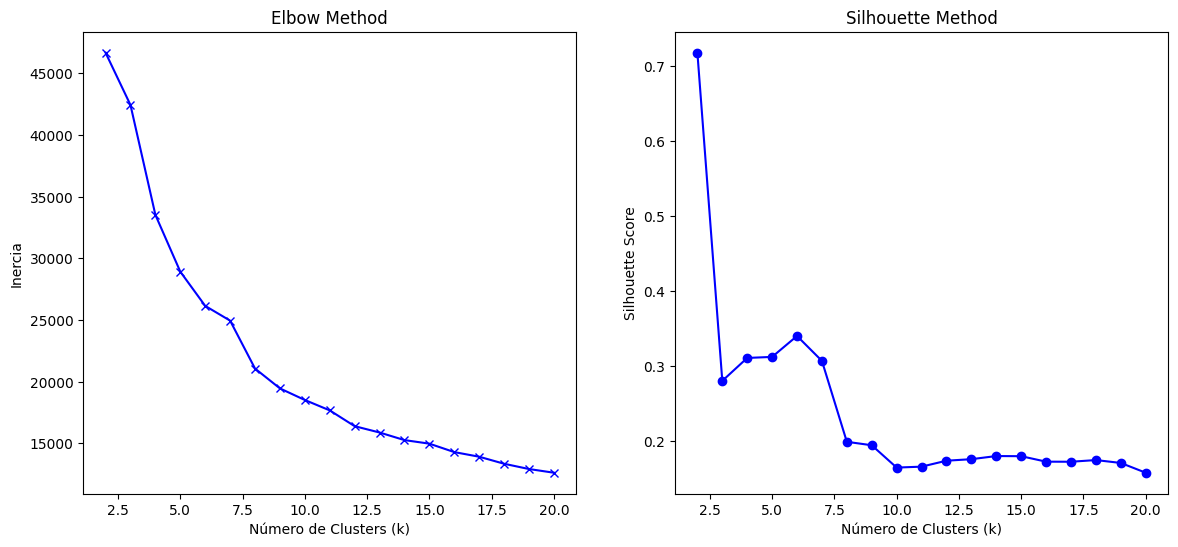

Cargas de PCA:
                       PC1       PC2
Num Sales         0.055834  0.078406
Total Units Sold  0.664031 -0.042945
Total Revenue     0.382568  0.315114
Avg Sell Price   -0.048430  0.321227
Std Sell Price   -0.026927  0.461299
Std Units Sold    0.636808 -0.112036
Avg Week         -0.007315 -0.266537
Std Week          0.005169 -0.686174
Avg Year         -0.030187 -0.149327

Contribuciones de las características a cada componente PCA:
                       PC1       PC2
Num Sales         0.003117  0.006148
Total Units Sold  0.440937  0.001844
Total Revenue     0.146359  0.099297
Avg Sell Price    0.002345  0.103187
Std Sell Price    0.000725  0.212797
Std Units Sold    0.405525  0.012552
Avg Week          0.000054  0.071042
Std Week          0.000027  0.470835
Avg Year          0.000911  0.022299


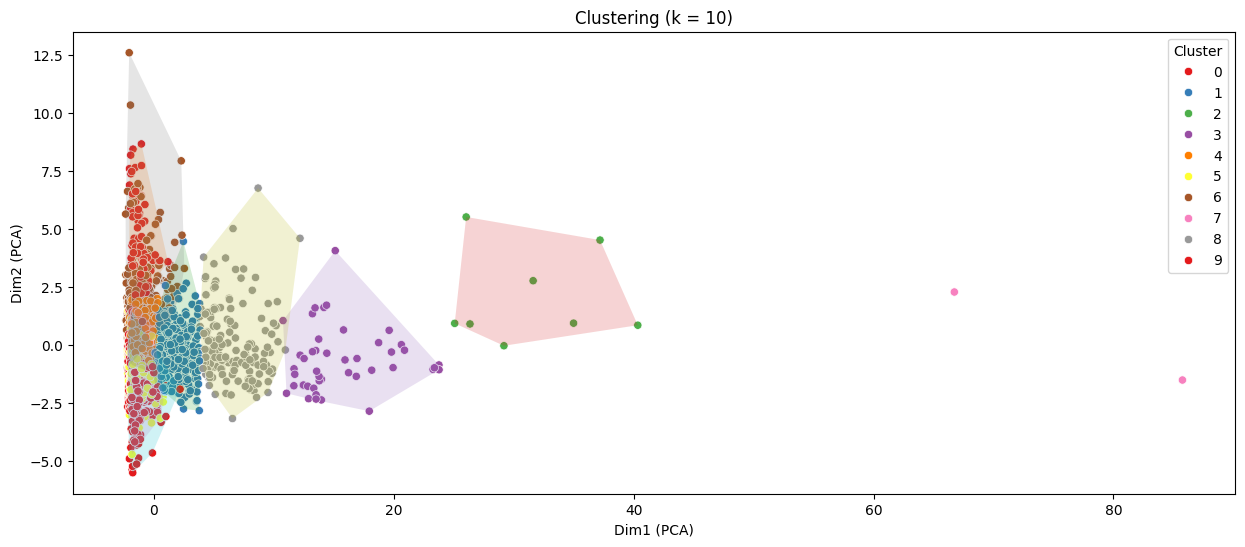

In [27]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    preprocessed_df, method='kmeans', n_clusters=optimal_k
)

c:\Users\alexa\Documents\GitHub\TFM_Retail\grupo2retail_0424\03_Clustering\clustering_module.py:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


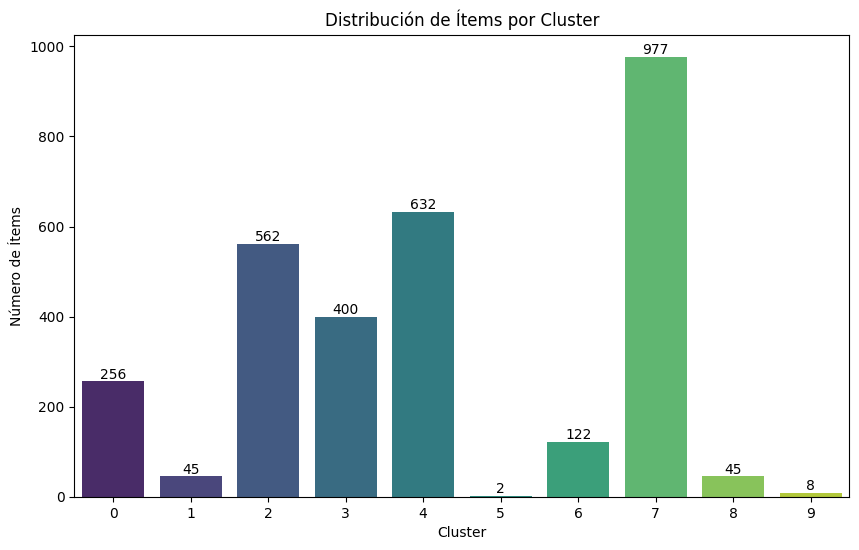

c:\Users\alexa\Documents\GitHub\TFM_Retail\grupo2retail_0424\03_Clustering\clustering_module.py:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=sorted_features, x=sorted_importances, palette='viridis')


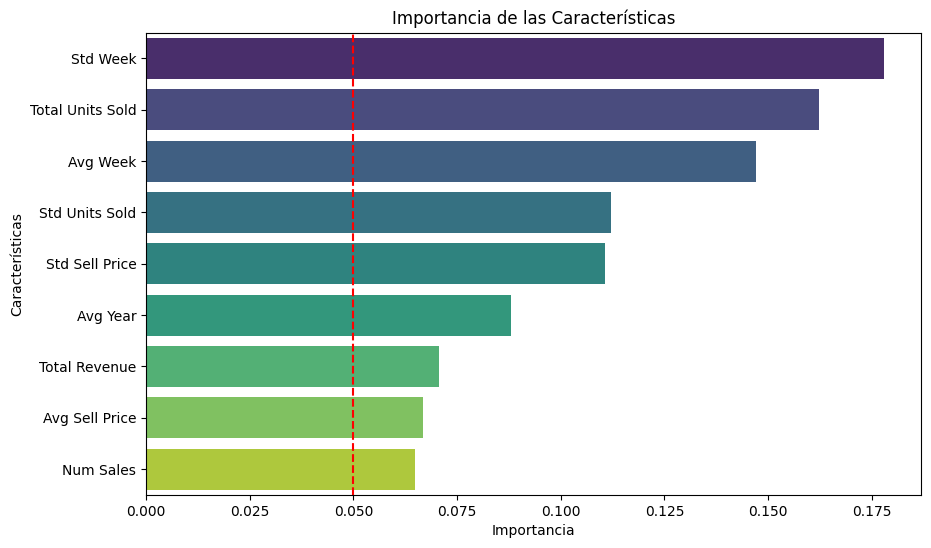

Cluster                  0          1         2         3         4  \
Num Sales        -0.145792   0.496436  0.269961 -0.670408 -0.471510   
Total Units Sold -0.111750  10.868295  1.318865 -0.152200 -0.156143   
Total Revenue     0.948616   4.692992  0.979845 -0.236015 -0.291798   
Avg Sell Price    2.307654  -0.505507 -0.057432  0.219185  0.059008   
Std Sell Price    3.049907  -0.234327  0.104521 -0.032064 -0.194828   
Std Units Sold   -0.133506  11.843446  1.335808  0.103119 -0.096066   
Avg Week         -0.042409  -0.125000 -0.321388 -0.394900  0.972383   
Std Week         -0.102476  -0.131129 -0.720447  1.848536  0.046010   
Avg Year          0.210465  -0.049279  0.038498  0.954421  0.660757   

Cluster                   5         6         7         8          9  
Num Sales          0.783168  0.526830  0.216899  0.483036   0.830817  
Total Units Sold  55.677322  5.036303  0.056024  3.102111  22.699352  
Total Revenue     26.600539  2.082718  0.102569  7.325398  16.432979  
Avg S

In [28]:
kmeans_cluster_labels, kmeans_cluster_summary = cm.perform_clustering_analysis(preprocessed_df, n_clusters=optimal_k)

In [29]:
# display(kmeans_cluster_labels)

In [30]:
display(kmeans_cluster_summary)

Cluster,0,1,2,3,4,5,6,7,8,9
Num Sales,-0.145792,0.496436,0.269961,-0.670408,-0.471510,0.783168,0.526830,0.216899,0.483036,0.830817
Total Units Sold,-0.111750,10.868295,1.318865,-0.152200,-0.156143,55.677322,5.036303,0.056024,3.102111,22.699352
Total Revenue,0.948616,4.692992,0.979845,-0.236015,-0.291798,26.600539,2.082718,0.102569,7.325398,16.432979
Avg Sell Price,2.307654,-0.505507,-0.057432,0.219185,0.059008,-0.526379,-0.491713,0.276255,1.299333,-0.273211
Std Sell Price,3.049907,-0.234327,0.104521,-0.032064,-0.194828,-0.116460,-0.187552,0.226519,0.903189,-0.043192
Std Units Sold,-0.133506,11.843446,1.335808,0.103119,-0.096066,47.278061,5.208786,-0.088337,3.281675,17.293510
Avg Week,-0.042409,-0.125000,-0.321388,-0.394900,0.972383,-0.162571,-0.040796,-0.287835,-0.009518,-0.129521
Std Week,-0.102476,-0.131129,-0.720447,1.848536,0.046010,-0.052394,0.027956,-0.366613,0.429442,-0.026853
Avg Year,0.210465,-0.049279,0.038498,0.954421,0.660757,-0.159374,-0.051596,-0.084496,-0.087285,-0.162340


# Descripcion de los clusters

## !!! PENDING

___
___

# IDEAS

## PRODUCTOS

### Rangos de precios de productos

In [31]:
# # Crear la feature matrix para los productos (items) enfocada en los precios
# feature_matrix_price, feature_defs_price = ft.dfs(
#     entityset=es,
#     target_dataframe_name="items",
#     agg_primitives=["mean", "std", "min", "max"],
#     trans_primitives=[],  # No necesitamos transformaciones adicionales aquí
#     max_depth=2
# )

# # Seleccionar y renombrar características relevantes para el análisis de precios
# selected_features_price = {
#     'MEAN(sales.sell_price)': 'avg_sell_price',  # Precio promedio de venta
#     'STD(sales.sell_price)': 'std_sell_price',   # Desviación estándar del precio de venta
#     'MIN(sales.sell_price)': 'min_sell_price',   # Precio mínimo de venta
#     'MAX(sales.sell_price)': 'max_sell_price',   # Precio máximo de venta
# }

### Efecto de eventos en ventas de productos

In [32]:
# # Crear la feature matrix para los productos (items) enfocada en el efecto de los eventos
# feature_matrix_events, feature_defs_events = ft.dfs(
#     entityset=es,
#     target_dataframe_name="items",
#     agg_primitives=["mean", "count", "sum"],
#     trans_primitives=[],  # No necesitamos transformaciones adicionales aquí
#     max_depth=2
# )

# # Seleccionar y renombrar características relevantes para el análisis del efecto de eventos
# selected_features_events = {
#     'MEAN(sales.event)': 'avg_event_sales_ratio',  # Promedio de ventas durante eventos
#     'COUNT(sales.event)': 'num_events',            # Número de eventos en los que el producto fue vendido
#     'SUM(sales.units)': 'total_units_sold',        # Total de unidades vendidas
#     'SUM(sales.raw_earn)': 'total_revenue',        # Ingresos totales generados
# }

## TIENDAS

__A priori parece NO TENER sentido aplicar clustering a tiendas con tan pocas muestras.__

### Rendimiento de ventas

In [33]:
# feature_matrix_sales, feature_defs_sales = ft.dfs(
#     entityset=es,
#     target_dataframe_name="shops",
#     agg_primitives=["sum", "mean", "std", "count"],
#     trans_primitives=[],  # No necesitamos transformaciones adicionales aquí
#     max_depth=2
# )

# # Seleccionar características relevantes para el rendimiento de ventas
# selected_features_sales = {
#     'SUM(sales.units)': 'total_units_sold',
#     'SUM(sales.raw_earn)': 'total_revenue',
#     'MEAN(sales.units)': 'avg_units_per_week',
#     'STD(sales.units)': 'std_units_sold',
#     'COUNT(sales)': 'num_sales',
# }

In [55]:
# Creacion caracteristicas para tiendas basadas en el comportamiento temporal de ventas
fc_config = {
    'target_df':'shops',
    'agg_primitives':["sum", "mean", "std", "count"],
    'trans_primitives':[],
    'max_depth':2
}

feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

# Revision definiciones caracteristicas creadas
fcm.get_features_descriptions(feature_defs)

# Seleccionar y renombrar características relevantes para el clustering de productos ventas/performance
selected_features_sales = {
    'SUM(sales.units)': 'total_units_sold',
    'SUM(sales.raw_earn)': 'total_revenue',
    'MEAN(sales.units)': 'avg_units_per_week',
    'STD(sales.units)': 'std_units_sold',
    'COUNT(sales)': 'num_sales',
}

feature_matrix = fcm.select_features(feature_matrix, selected_features_sales)

# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix)

display(filtered_feature_matrix.head(5))

# Renombrar características si es necesario
feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, selected_features)

display(feature_matrix_renamed.head(5))

# Preprocesamiento datos
scaled_df = pm.preprocess_features(feature_matrix_renamed)

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\entityset\entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\entityset\entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index, make_index
  warnings.warn(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x00000266619EEDE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided ca

<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "store_code" in "shops".
<Feature: STD(sales.raw_earn)>: The standard deviation of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".
<Feature: STD(sales.sell_price)>: The standard deviation of the "sell_price" of all instances of "sales" for each "store_code" in "shops".
<Feature: STD(sales.u

,SUM(sales.units),STD(sales.units),COUNT(sales)
store_code,,,
NYC_1,7698216.0,29.263064,534101
NYC_2,5685475.0,19.189855,474612
NYC_3,11188180.0,46.523097,552278
NYC_4,4103676.0,13.680758,482465
BOS_1,5595292.0,25.052432,495985


,Total Units Sold,Std Units Sold,Num Sales
store_code,,,
NYC_1,7698216.0,29.263064,534101
NYC_2,5685475.0,19.189855,474612
NYC_3,11188180.0,46.523097,552278
NYC_4,4103676.0,13.680758,482465
BOS_1,5595292.0,25.052432,495985


Cat cols: 0
Num cols: 3


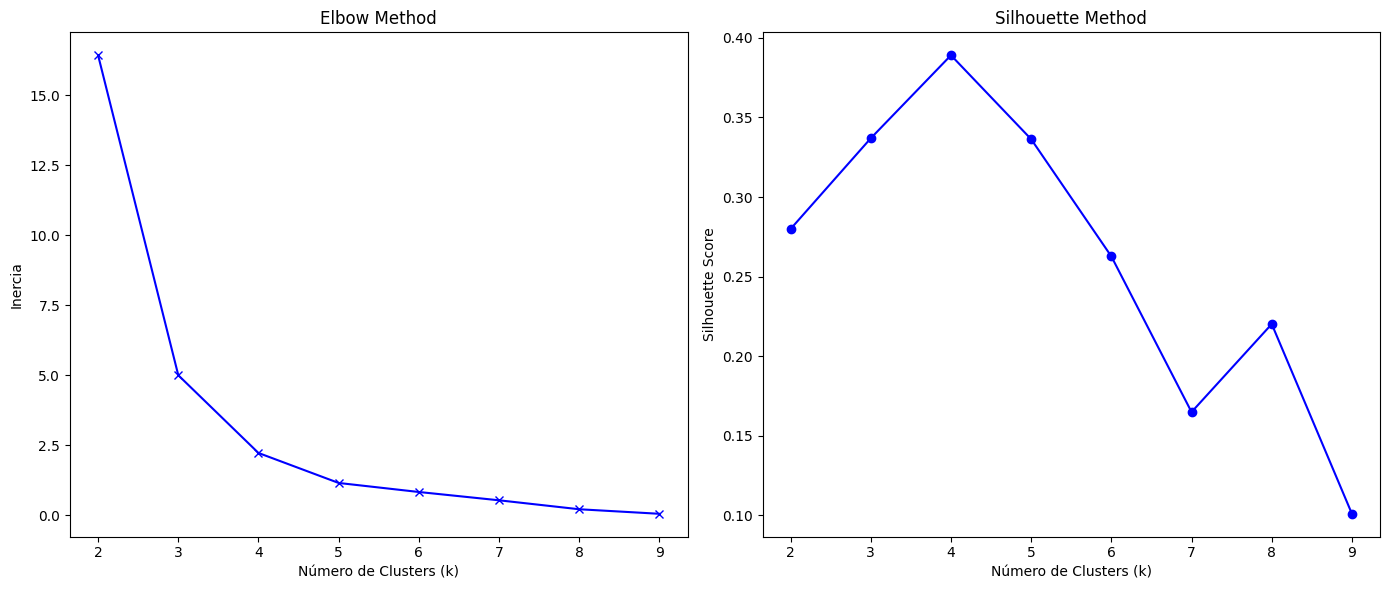

In [58]:
km_m.plot_elbow_silhouette(scaled_df, 9) # No puede haber mas clusters que etiquetas

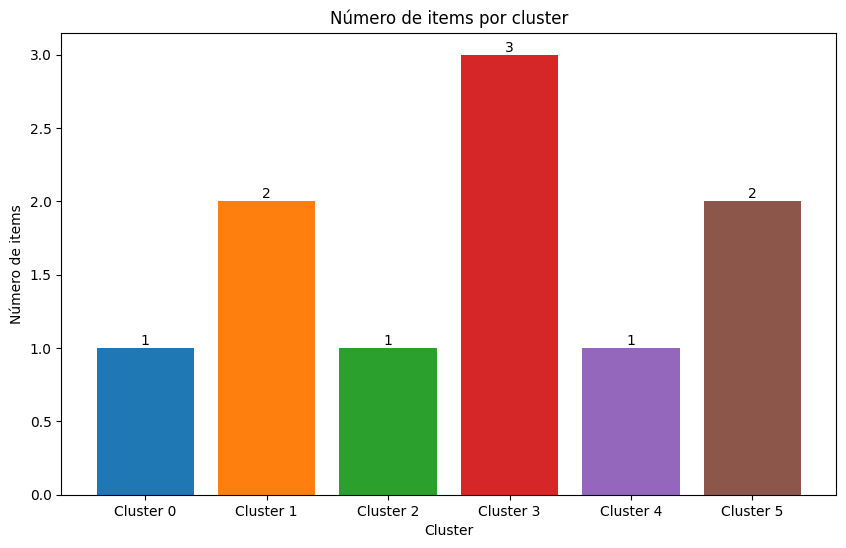

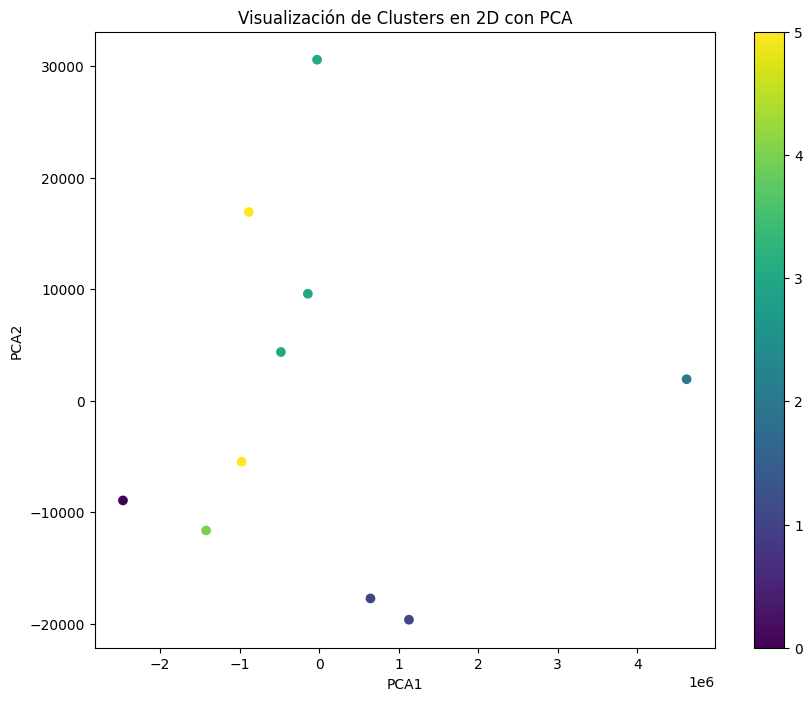

,PCA1,PCA2,Cluster
0,1.128972e+06,-19636.091194,1
1,-8.843160e+05,16927.332548,5
2,4.618917e+06,1932.879379,2
3,-2.465923e+06,-8939.175383,0
4,-9.742498e+05,-5471.313061,5


Principal Component 1: 1.00
Principal Component 2: 0.00
Principal Component 3: 0.00
Principal Component 4: 0.00


ValueError: Image size of 996x102021 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x500 with 1 Axes>

Cat cols: 0
Num cols: 3


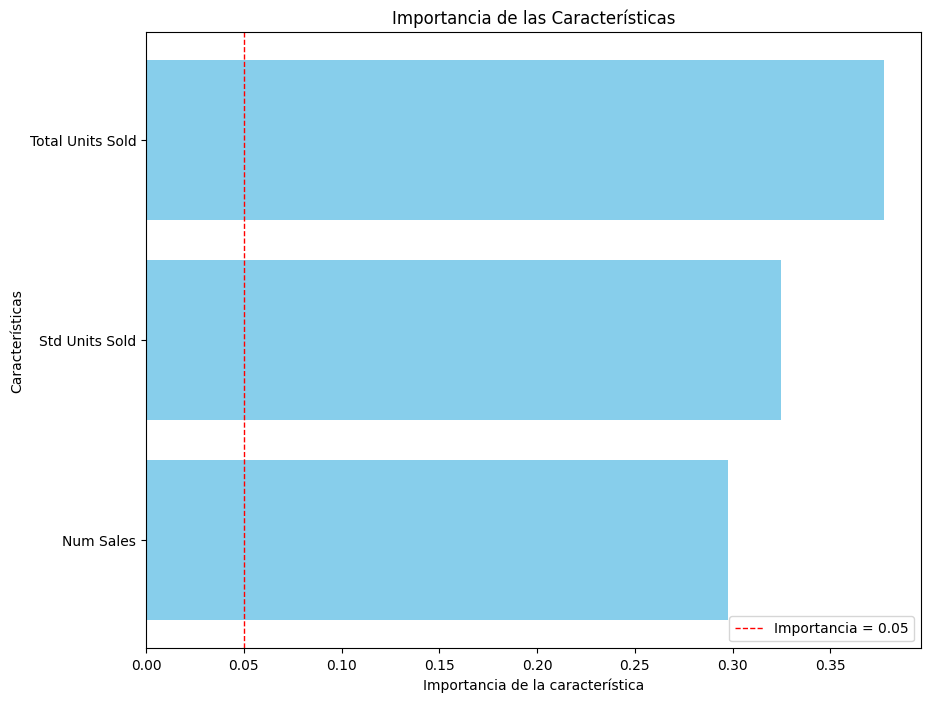

,Feature,Importance
0,Total Units Sold,0.377435
1,Std Units Sold,0.324792
2,Num Sales,0.297773


In [59]:
optimal_k = 6 # Segun elbow

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

km_m.pca_variance_plot(feature_matrix_with_clusters)

# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

# sales_importance_df = km_m.get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
sales_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=0.05)

display(sales_importance_df.head(10))

### Mix de productos vendidos

In [34]:
# # Crear la feature matrix para las tiendas basada en el mix de productos
# feature_matrix_product_mix, feature_defs_product_mix = ft.dfs(
#     entityset=es,
#     target_dataframe_name="shops",
#     agg_primitives=["sum", "mean", "count"],
#     trans_primitives=[],  # No necesitamos transformaciones adicionales aquí
#     max_depth=2
# )

# # Seleccionar características relevantes para el mix de productos vendidos
# selected_features_product_mix = {
#     'SUM(sales.units)': 'total_units_sold',
#     'COUNT(sales.category)': 'num_categories_sold',
#     'MEAN(sales.sell_price)': 'avg_sell_price',
#     'SUM(sales.department)': 'num_departments_sold'
# }

### Comportamiento temporal de ventas

In [35]:
# # Crear la feature matrix para las tiendas basada en el comportamiento temporal de ventas
# feature_matrix_temporal, feature_defs_temporal = ft.dfs(
#     entityset=es,
#     target_dataframe_name="shops",
#     agg_primitives=["mean", "std"],
#     trans_primitives=[],  # No necesitamos transformaciones adicionales aquí
#     max_depth=2
# )

# # Seleccionar características relevantes para el comportamiento temporal
# selected_features_temporal = {
#     'MEAN(sales.week)': 'avg_week',
#     'STD(sales.week)': 'std_week',
#     'MEAN(sales.year)': 'avg_year',
#     'STD(sales.year)': 'std_year',
# }

In [38]:
# Creacion caracteristicas para tiendas basadas en el comportamiento temporal de ventas
fc_config = {
    'target_df':'shops',
    'agg_primitives':['mean', 'std'],
    'trans_primitives':[],
    'max_depth':2
}

feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

# Revision definiciones caracteristicas creadas
fcm.get_features_descriptions(feature_defs)

# Seleccionar y renombrar características relevantes para el clustering de productos ventas/performance
selected_features_temporal = {
    'MEAN(sales.week)': 'avg_week',
    'STD(sales.week)': 'std_week',
    'MEAN(sales.year)': 'avg_year',
    'STD(sales.year)': 'std_year',
}

feature_matrix = fcm.select_features(feature_matrix, selected_features_temporal)

# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix)

display(filtered_feature_matrix.head(5))

# Renombrar características si es necesario
feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, selected_features)

display(feature_matrix_renamed.head(5))

# Preprocesamiento datos
scaled_df = pm.preprocess_features(feature_matrix_renamed)

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\entityset\entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\entityset\entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index, make_index
  warnings.warn(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x00000266619EEDE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided ca

<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "store_code" in "shops".
<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "store_code" in "shops".
<Feature: STD(sales.raw_earn)>: The standard deviation of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".
<Feature: STD(sales.sell_price)>: The standard deviation of the "sell_price" of all instances of "sales" for each "store_code" in "shops".
<Feature: STD(sales.units)>: The standard deviation of the "units" of all instances of "sales" for each "store_code" in

,MEAN(sales.week),STD(sales.week),MEAN(sales.year),STD(sales.year)
store_code,,,,
NYC_1,25.952865,15.217839,2013.528791,1.494006
NYC_2,26.073260,15.327575,2013.605870,1.512879
NYC_3,26.025523,15.285107,2013.549663,1.492768
NYC_4,25.996731,15.247461,2013.549835,1.499930
BOS_1,25.951962,15.243287,2013.511169,1.507499


,Avg Week,Std Week,Avg Year,Std(Sales.Year)
store_code,,,,
NYC_1,25.952865,15.217839,2013.528791,1.494006
NYC_2,26.073260,15.327575,2013.605870,1.512879
NYC_3,26.025523,15.285107,2013.549663,1.492768
NYC_4,25.996731,15.247461,2013.549835,1.499930
BOS_1,25.951962,15.243287,2013.511169,1.507499


Cat cols: 0
Num cols: 4


In [45]:
display(scaled_df.head())

display(scaled_df.shape)

,Avg Week,Std Week,Avg Year,Std(Sales.Year)
0,-0.253913,-1.288504,-0.248072,-0.376274
1,1.198394,1.195378,0.762306,0.949179
2,0.622557,0.234109,0.025528,-0.463267
3,0.275243,-0.618009,0.027774,0.039718
4,-0.264799,-0.712472,-0.479078,0.571338


(10, 4)

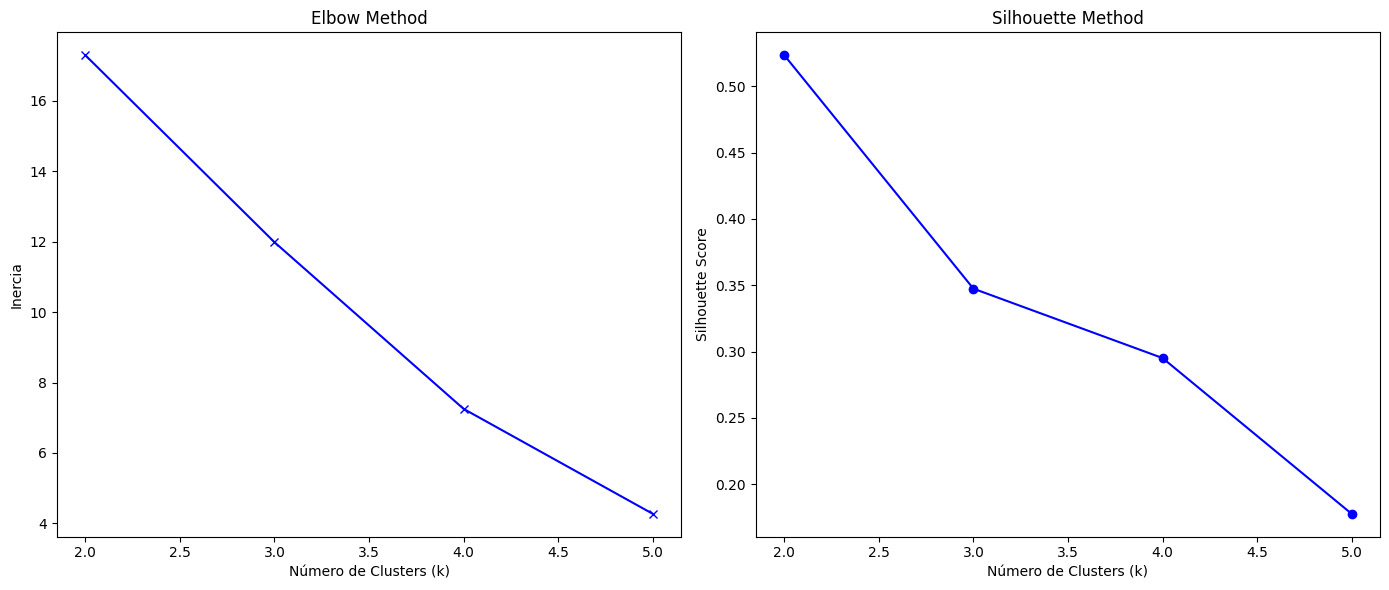

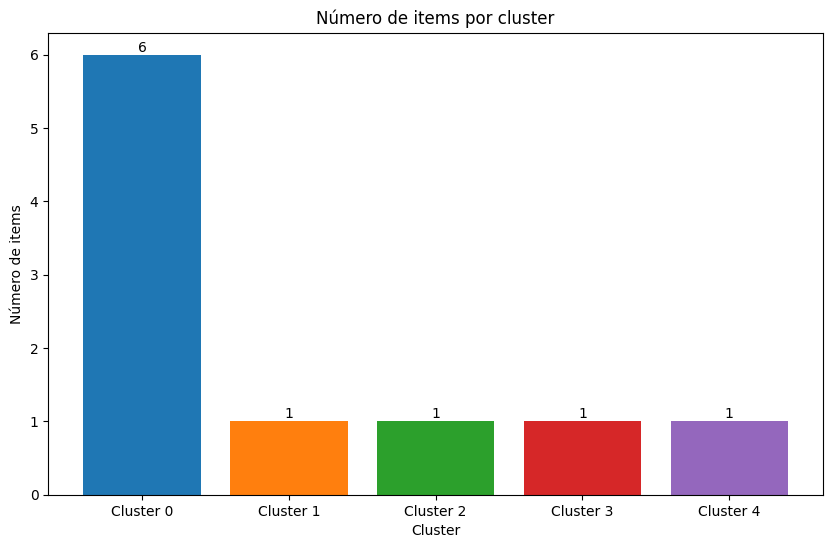

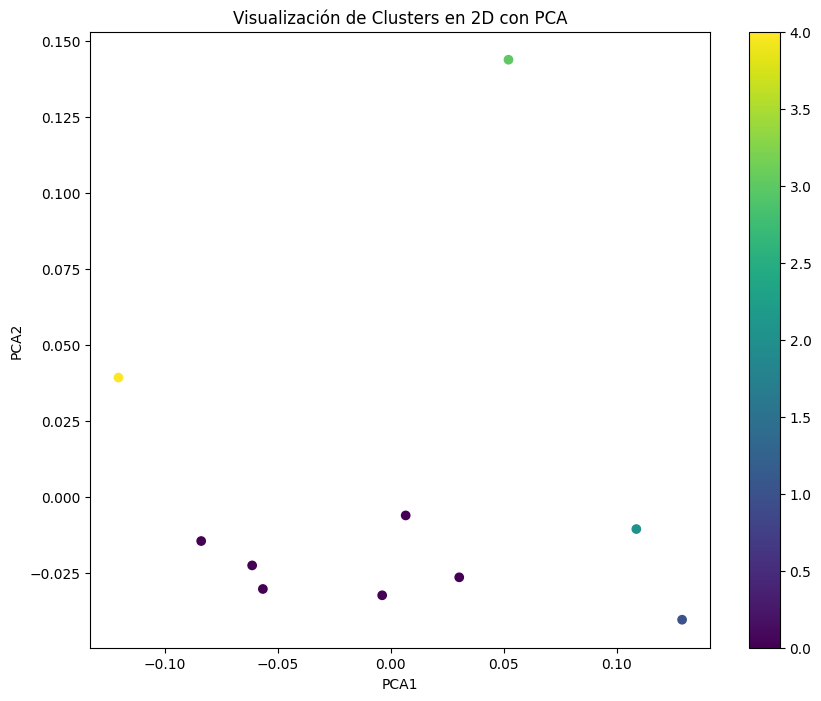

,PCA1,PCA2,Cluster
0,-0.056714,-0.030256,0
1,0.108766,-0.010551,2
2,0.030297,-0.026422,0
3,-0.003853,-0.032332,0
4,-0.061470,-0.022509,0


Principal Component 1: 1.00
Principal Component 2: 0.00
Principal Component 3: 0.00
Principal Component 4: 0.00
Principal Component 5: 0.00


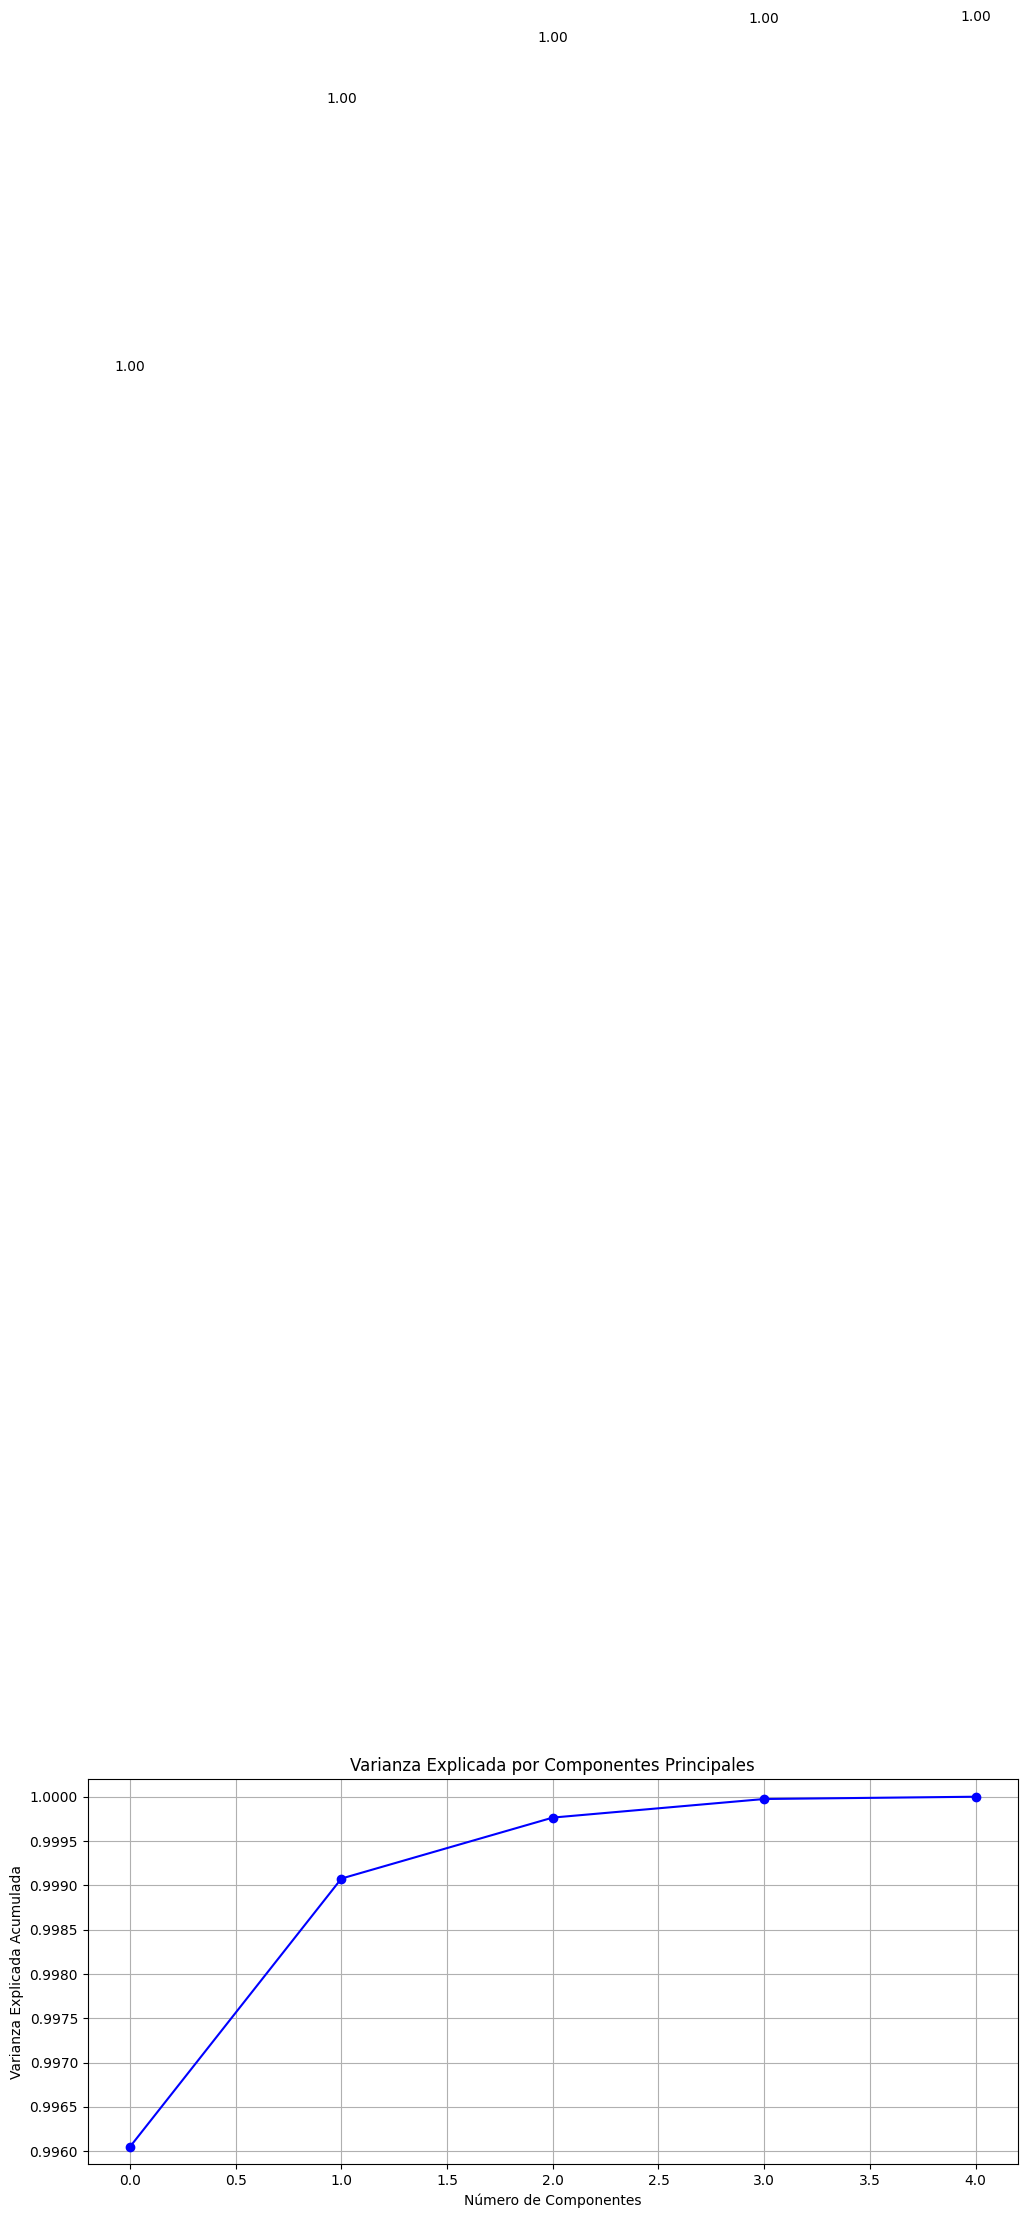

Cat cols: 0
Num cols: 4


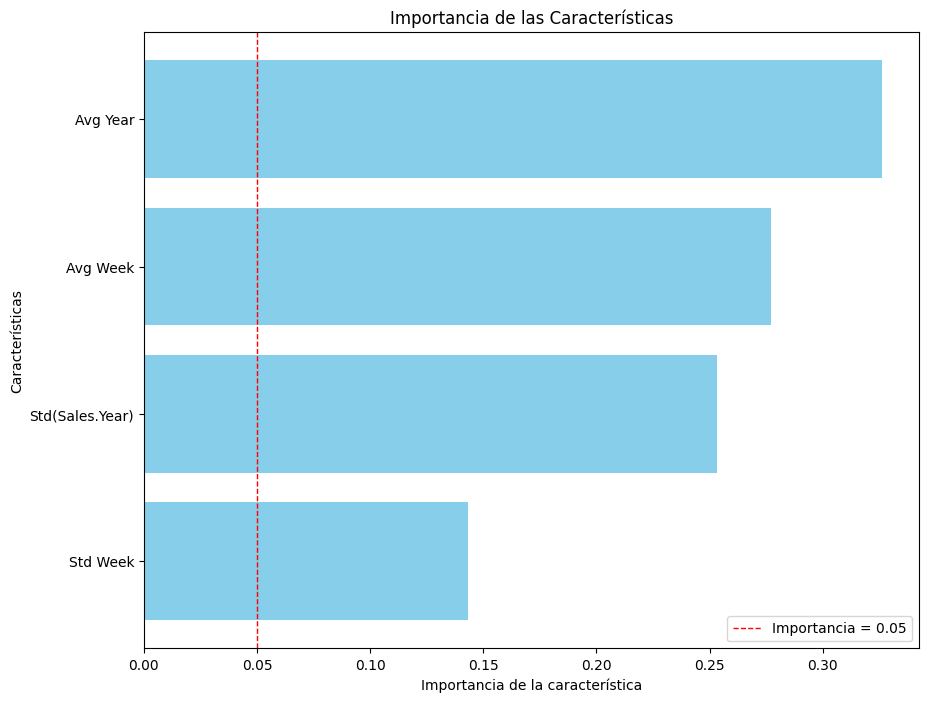

,Feature,Importance
0,Avg Year,0.326218
1,Avg Week,0.277105
2,Std(Sales.Year),0.253313
3,Std Week,0.143363


In [54]:
km_m.plot_elbow_silhouette(scaled_df, 5) # No puede haber mas clusters que etiquetas

optimal_k = 5 # Segun silueta

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

km_m.pca_variance_plot(feature_matrix_with_clusters)

# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

# sales_importance_df = km_m.get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
sales_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=0.05)

display(sales_importance_df.head(10))

In [50]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    feature_matrix_renamed, method='kmeans', n_clusters=2
)

# Este error se da cuando el numero clusters es igual o mayor que el numero de etiquetas!!!

ValueError: Number of labels is 10. Valid values are 2 to n_samples - 1 (inclusive)